# Publications Hypergraph Demo Notebook

This notebook is used to replcate the use case experiment in the paper **PAPER LINK HERE** that demonstrates the use of the hypergraph interchange formation (HIF).

The following hypergraph libraries have the HIF loading and saving functions allowing for the analysis of the same hypergraph over each library:
* HyperNetX (HNX)
* HyperGraphX (HGX)
* SimpleHypergraphs
* TopoNetX
* Hypergraph Analysis Toolbox (HAT)
* compleX Group Interactions (XGI)

## Publications Data as a Hypergraph

This dataset consists of open source publications with the keyword "Hypergraph" and was collected from ArXiv, Biorxiv, DBLP and Osti. The Hypergraph has hyperedges as publications and nodes as authors. The hyperedges have attributes including funding agencies, abstract, publication date, tags, and source, while the nodes have the attributes of institutions.

In [1]:
# import standard packages for analysis and plotting
import json
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
file_path = "data/publications.hif.json"
with open(file_path, "r") as f:
    HIF_publications = json.load(f)

#optional to load in main component directly
main_component_file_path = "data/publications_main_component.hif.json"

# HyperNetX

Here we demo loading in the hypergraph using HNX and demoing the unique homology capabilities of the library.

In [3]:
import hypernetx as hnx

In [4]:
H_hnx = hnx.from_hif(HIF_publications)

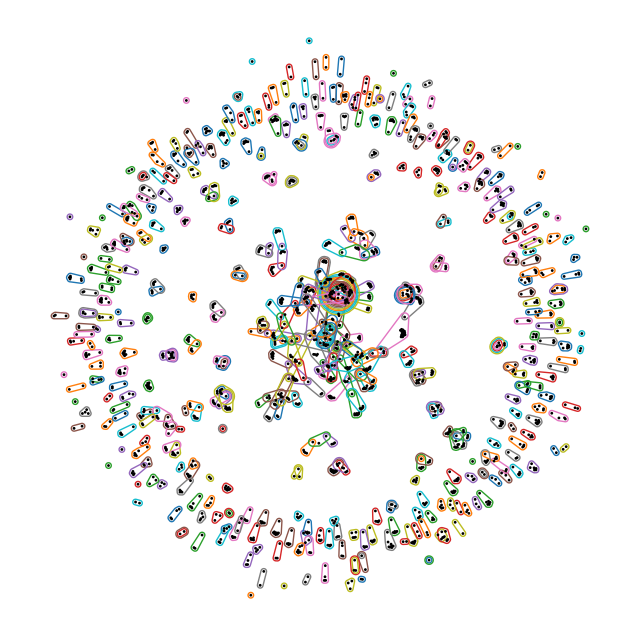

In [5]:
hnx.draw(
    H_hnx,
    with_edge_labels=False,
    with_node_labels=False,
    node_radius=0.2,
    edges_kwargs={"lw": 0.5},
)

In [6]:
# Getting the main connected component of hypergraph
import numpy as np

Hs = list(H_hnx.s_component_subgraphs(s=1, return_singletons=False))
I = np.argsort([len(H_CC.incidences.dataframe) for H_CC in Hs])
Hs = [Hs[i] for i in I]
H = Hs[-1]

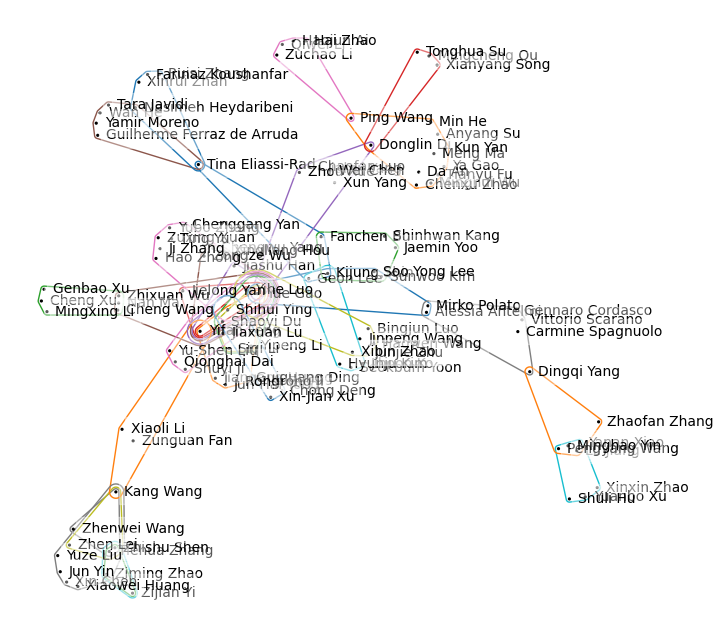

In [7]:
pos = hnx.draw(
    H,
    with_edge_labels=False,
    with_node_labels=True,
    node_radius=0.2,
    edges_kwargs={"lw": 0.5},
    return_pos=True,
)
plt.show()

/var/folders/12/5tnqqv2d58qb9hs_fcf9tcdh0000gp/T/ipykernel_45380/3541571744.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


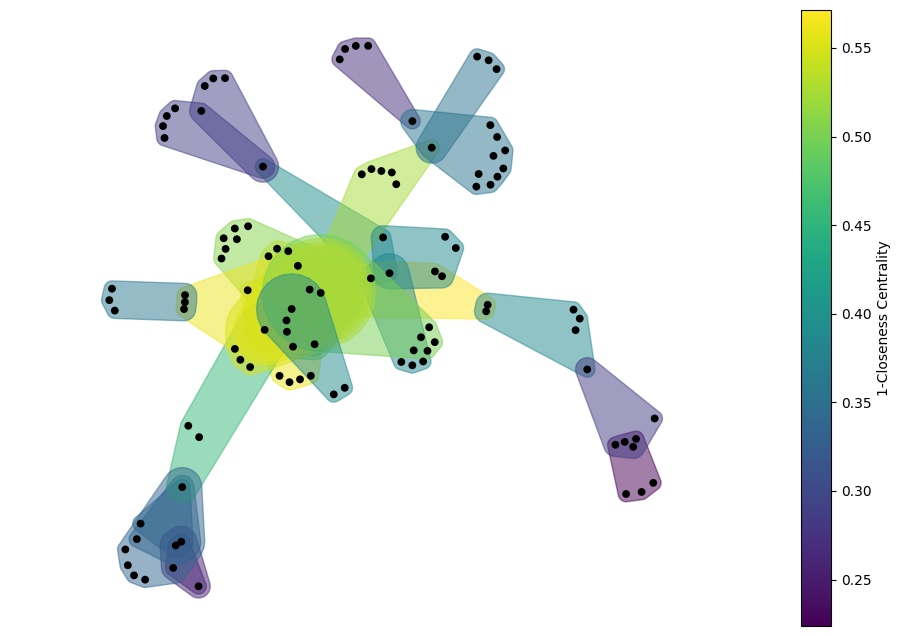

In [8]:
import hypernetx as hnx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming your hypergraph 'H' is already defined
s = 1
edge_centrality = hnx.s_closeness_centrality(H, s=s)

# Get the centrality values and the edges
edges = list(H.edges)
centrality_values = np.array([edge_centrality[e] for e in edges])

# Normalize the centrality values to the range [0, 1]
if centrality_values.size > 0:
    normalized_centrality = (centrality_values - np.min(centrality_values)) / (
        np.max(centrality_values) - np.min(centrality_values)
    )
else:
    normalized_centrality = np.array([])  # Handle the case of no edges

# Choose a colormap
cmap = cm.get_cmap("viridis")

# Map the normalized centrality values to colors
edge_colors = cmap(normalized_centrality)

# Create a dictionary to pass to edges_kwargs for coloring
edge_style = {}
for i, edge in enumerate(edges):
    if i < len(edge_colors):
        edge_style[edge] = edge_colors[i]

# Create the hypergraph plot
fig, ax = plt.subplots(figsize=(12, 8))
hnx.draw(
    H,
    pos=pos,
    with_edge_labels=False,
    with_node_labels=False,
    node_radius=0.5,
    edges_kwargs={"color": list(edge_style.values()), "lw": 2, "alpha": 0.5},
    ax=ax,
)


# Add the colorbar
sm = cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=np.min(centrality_values), vmax=np.max(centrality_values)),
)
sm.set_array([])  # For older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(f"{s}-Closeness Centrality")


plt.show()

In [9]:
s = 1
print(f"The {s}-closeness centrality of the edges in hypergraph H is:")
print("-" * 100)

d = hnx.s_closeness_centrality(H, s=s)
for e in H.edges:
    print(f"{e}: {d[e]}")

The 1-closeness centrality of the edges in hypergraph H is:
----------------------------------------------------------------------------------------------------
A Survey on Hypergraph Mining: Patterns, Tools, and Generators: 0.3950617283950617
Hyper-YOLO: When Visual Object Detection Meets Hypergraph Computation: 0.5614035087719298
HyperSMOTE: A Hypergraph-based Oversampling Approach for Imbalanced Node Classifications: 0.2601626016260163
LightHGNN: Distilling Hypergraph Neural Networks into MLPs for $100\times$ Faster Inference: 0.5614035087719298
Hyper-3DG: Text-to-3D Gaussian Generation via Hypergraph: 0.5245901639344263
Assigning Entities to Teams as a Hypergraph Discovery Problem: 0.2882882882882883
Hypergraph based Understanding for Document Semantic Entity Recognition: 0.26666666666666666
Towards Multi-agent Policy-based Directed Hypergraph Learning for Traffic Signal Control: 0.3368421052631579
Hypergraph-based Multi-View Action Recognition using Event Cameras: 0.5
Multimodal F

# XGI

In [10]:
import xgi

In [11]:
H_xgi = xgi.read_hif(file_path)
testH = H_xgi.cleanup(in_place=False)

/opt/homebrew/Caskroom/miniforge/base/envs/xgi/lib/python3.13/copy.py:88: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  rv = reductor(4)


(<Axes: >,
 (<matplotlib.collections.PathCollection at 0x1413f7b10>,
  <matplotlib.collections.LineCollection at 0x1413f79d0>))

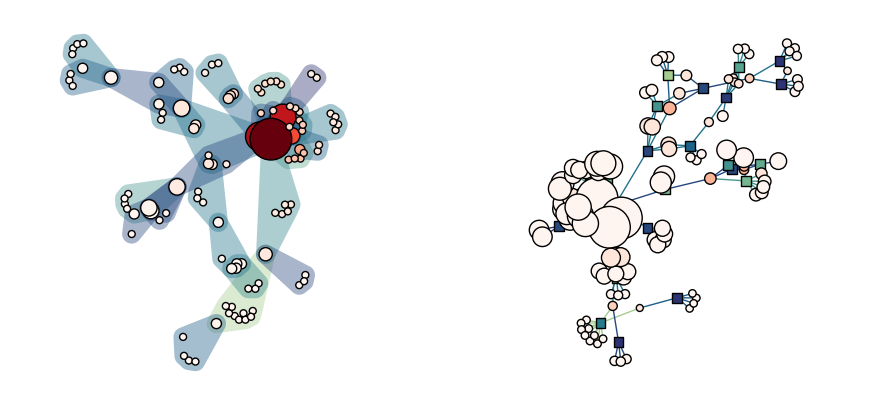

In [12]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
xgi.draw(
    testH,
    hull=True,
    node_size=testH.nodes.degree,
    node_fc=testH.nodes.clique_eigenvector_centrality,
)
plt.subplot(122)
xgi.draw_bipartite(
    testH,
    node_fc=testH.nodes.degree,
    node_size=testH.nodes.average_neighbor_degree,
    edge_marker_fc=testH.edges.node_edge_centrality,
)

Yue Gao has published the most papers in this dataset with 14
Hypergraph Cortical Cytoarchitectonic Parcellation with Multimodal Canine Brain Atlas has the most co-authors with 17


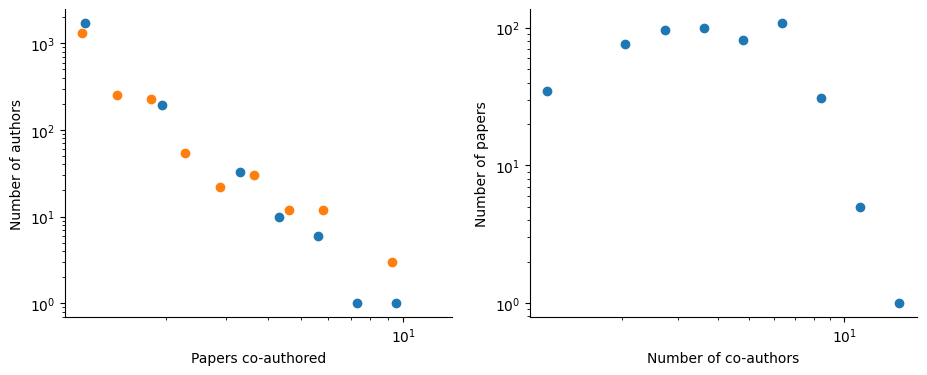

In [13]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
author = H_xgi.nodes.degree.argmax()

print(
    f"{author} has published the most papers in this dataset with {H_xgi.nodes.degree[author]}"
)
hist = H_xgi.nodes.degree.ashist(log_binning=True)
plt.scatter(hist["bin_center"], hist["value"])
hist = H_xgi.nodes.average_neighbor_degree.ashist(log_binning=True)
plt.scatter(hist["bin_center"], hist["value"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Papers co-authored")
plt.ylabel("Number of authors")
sns.despine()

plt.subplot(122)
paper = H_xgi.edges.size.argmax()
print(f"{paper} has the most co-authors with {H_xgi.edges.size[paper]}")
hist = H_xgi.edges.size.ashist(log_binning=True)
plt.scatter(hist["bin_center"], hist["value"])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of co-authors")
plt.ylabel("Number of papers")
sns.despine()

# HAT

In [14]:
from HAT import Hypergraph as HatHypergraph
from HAT.metrics import nonlinear_eigenvector_centrality

H_hat = HatHypergraph.from_hif(HIF_publications)
node_centrality, edge_centrality = nonlinear_eigenvector_centrality(H_hat, model='Linear')
i, e = max(enumerate(edge_centrality), key=lambda y: y[1])
name = H_hat.edges["edge"][i]
print(f'{name}: {e}')

Iterations:   2%|▏         | 68/3000 [00:01<00:58, 50.11it/s]

Hyper-YOLO: When Visual Object Detection Meets Hypergraph Computation: 0.10612699123500413


# HGX

# SimpleHypergraphs

In [17]:
run_julia = True # Set to True to execute the Julia code
if run_julia:
    import julia
    # Initialize Julia explicitly with compiled_modules=False
    # This line MUST be the first interaction with the julia package after import
    jl = julia.Julia(compiled_modules=False)
    
    from julia import Main # Now you can safely import Main
    
    # --- Define the actual file path (if you still want to use it for later) ---
    file_path = "data/publications.hif.json" # Your specified file path
    
    # --- Julia code provided in the prompt ---
    # This string contains the Julia code to be executed.
    loading_simple_hypergraphs = """
    using Pkg
    Pkg.add(url="https://github.com/AleksanderWWW/SimpleHypergraphs.jl.git", rev="aw/hif-import-export")

    using SimpleHypergraphs
    """
    # --- 1. Load Julia module ---
    Main.eval(loading_simple_hypergraphs)
    
    # Pass the Python file_path string to Julia
    Main.file_to_load_jl = file_path
    
    # --- 2. Run the specified Julia code to load the hypergraph from file ---
    # Reverting to the paper's exact syntax for hg_load,
    # trusting that 'using SimpleHypergraphs' exports HIF_Format and Hypergraph.

    loaded_hg_jl = Main.eval("""
    loaded_hg = hg_load(
        file_to_load_jl;
        format=HIF_Format(), # As per paper's example
        HType=Hypergraph,    # As per paper's example
        T=Int, V=String, E=String
    )
    """)
    
    print(f"Hypergraph successfully loaded into Julia from file as: {loaded_hg_jl}")
    
    num_vertices_jl = Main.nv(loaded_hg_jl)
    num_hyperedges_jl = Main.ne(loaded_hg_jl)
    
    print(f"\nNumber of vertices in Julia Hypergraph: {num_vertices_jl}")
    print(f"Number of hyperedges in Julia Hypergraph: {num_hyperedges_jl}")
    
    
    Main.eval("""
    function get_hyperedge_sizes_julia_counts(h::SimpleHypergraphs.Hypergraph)
        sizes = Dict{Int, Int}()
        for he in SimpleHypergraphs.hyperedges(h)
            len = length(he)
            sizes[len] = get(sizes, len, 0) + 1
        end
        return sizes
    end
    """)
    hyperedge_sizes_from_jl = Main.get_hyperedge_sizes_julia_counts(loaded_hg_jl)
    print(f"Distribution of hyperedge sizes (from Julia): {dict(hyperedge_sizes_from_jl)}")

JuliaError: Exception 'ArgumentError' occurred while calling julia code:
const PyCall = Base.require(Base.PkgId(Base.UUID("438e738f-606a-5dbb-bf0a-cddfbfd45ab0"), "PyCall"))

In [ ]:
run_julia = False
if run_julia:
    import julia
    # Initialize Julia explicitly with compiled_modules=False
    # This line MUST be the first interaction with the julia package after import
    jl = julia.Julia(compiled_modules=False)
    
    from julia import Main # Now you can safely import Main
    
    # --- Define the actual file path ---
    file_path = "data/publications.hif.json" # Your specified file path
    
    # --- 1. Load Julia module ---
    # This makes SimpleHypergraphs and related formats available in Julia's Main scope.
    # We will evaluate this explicitly to ensure all exports are active.
    Main.eval("using SimpleHypergraphs")
    
    # Pass the Python file_path string to Julia
    Main.file_to_load_jl = file_path
    
    # --- 2. Run the specified Julia code to load the hypergraph ---
    # Reverting to the paper's exact syntax for hg_load,
    # trusting that 'using SimpleHypergraphs' exports HIF_Format and Hypergraph.
    loaded_hg_jl = Main.eval("""
    loaded_hg = hg_load(
        file_to_load_jl;
        format=HIF_Format(), # As per paper's example
        HType=Hypergraph,    # As per paper's example
        T=Int, V=String, E=String
    )
    """)
    
    print(f"Hypergraph successfully loaded into Julia as: {loaded_hg_jl}")
    
    
    num_vertices_jl = Main.nv(loaded_hg_jl)
    num_hyperedges_jl = Main.ne(loaded_hg_jl)
    
    print(f"\nNumber of vertices in Julia Hypergraph: {num_vertices_jl}")
    print(f"Number of hyperedges in Julia Hypergraph: {num_hyperedges_jl}")
    
    
    Main.eval("""
    function get_hyperedge_sizes_julia_counts(h::SimpleHypergraphs.Hypergraph)
        sizes = Dict{Int, Int}()
        for he in SimpleHypergraphs.hyperedges(h)
            len = length(he)
            sizes[len] = get(sizes, len, 0) + 1
        end
        return sizes
    end
    """)
    hyperedge_sizes_from_jl = Main.get_hyperedge_sizes_julia_counts(loaded_hg_jl)
    print(f"Distribution of hyperedge sizes (from Julia): {dict(hyperedge_sizes_from_jl)}")